# Neural Price

Author: Willem Bonnaffé

Date: 01.08.2024

In [1]:
##############
## INITIATE ##
##############

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#
###

### Ground Truth Model Overview

The ground truth model used to generate the artificial time series is based on a system of ordinary differential equations (ODEs) that describe the dynamics of a population's phenotype distribution over time. This model captures the interplay between population size, resource availability, and phenotype adaptation, following principles from evolutionary biology.

### Model Description

The system of ODEs consists of three main equations:

1. **Resource Dynamics**:
   $$
   \frac{dR}{dt} = \iota - \alpha R N
   $$
   - **Variables**:
     - $ R(t) $: Resource availability at time $t$.
     - $ N(t) $: Total population size at time $t$.
   - **Parameters**:
     - $ \iota $: Rate of resource replenishment.
     - $ \alpha $: Rate at which the population consumes the resource.

2. **Population Size Dynamics**:
   $$
   \frac{dN}{dt} = \alpha R N f(\bar{z}, z_{opt}, \sigma_z, \sigma_{opt}) - \beta N
   $$
   - **Variables**:
     - $ N(t) $: Total population size at time $t$.
     - $ \bar{z}(t) $: Mean phenotype in the population at time $t$.
   - **Parameters**:
     - $ \alpha $: Resource consumption rate.
     - $ \beta $: Baseline mortality rate.
     - $ z_{opt} $: Optimal phenotype value.
     - $ \sigma_z $: Standard deviation of the phenotype distribution in the population.
     - $ \sigma_{opt} $: Standard deviation of the optimal phenotype distribution.
   - **Function**:
     - $ f(\bar{z}, z_{opt}, \sigma_z, \sigma_{opt}) $: Represents the fitness of the population, modeled as a Gaussian function of the mean phenotype and the optimal phenotype.

3. **Phenotype Dynamics**:
   $$
   \frac{d\bar{z}}{dt} = \alpha R f(\bar{z}, z_{opt}, \sigma_z, \sigma_{opt}) \frac{\sigma_z^2}{\sigma_z^2 + \sigma_{opt}^2} (z_{opt} - \bar{z})
   $$
   - **Variables**:
     - $ \bar{z}(t) $: Mean phenotype in the population at time $t$.
   - **Parameters**:
     - $ \alpha $: Resource consumption rate.
     - $ \sigma_z $: Standard deviation of the phenotype distribution in the population.
     - $ \sigma_{opt} $: Standard deviation of the optimal phenotype distribution.
     - $ z_{opt} $: Optimal phenotype value.
   - **Function**:
     - The equation captures how the mean phenotype evolves over time, driven by the difference between the current mean phenotype and the optimal phenotype, modulated by resource availability and fitness.

### Interpretation of the Model

- **Resource Availability**: The resource dynamics equation models how resources are consumed by the population and replenished over time. A balance between resource consumption and replenishment is crucial for population sustainability.
- **Population Size**: The population size dynamics equation describes how the population grows or declines based on resource availability and the match between the population's mean phenotype and the optimal phenotype.
- **Phenotype Adaptation**: The phenotype dynamics equation captures the evolutionary process where the mean phenotype shifts towards the optimal phenotype under selective pressure, influenced by resource availability and fitness.

### Parameters and Variables

- **$ R(t) $**: Resource availability at time $t$.
- **$ N(t) $**: Total population size at time $t$.
- **$ \bar{z}(t) $**: Mean phenotype in the population at time $t$.
- **$ \iota $**: Rate of resource replenishment.
- **$ \alpha $**: Rate of resource consumption by the population.
- **$ \beta $**: Baseline mortality rate of the population.
- **$ z_{opt} $**: Optimal phenotype value for the population.
- **$ \sigma_z $**: Standard deviation of the phenotype distribution in the population.
- **$ \sigma_{opt} $**: Standard deviation of the optimal phenotype distribution.

### Application

This model serves as the foundation for generating the artificial time series, providing insights into how population dynamics and phenotype evolution interact under various conditions. The outputs of this model, particularly the time series of the mean phenotype, are then used to test and evaluate interpolation methods, such as neural networks, which aim to estimate key evolutionary dynamics like the covariance between phenotype and population growth rate.


In [2]:
#####################
## MODEL FUNCTIONS ##
#####################

def dnorm(x, mu, sigma):
    return 1 / torch.sqrt(2 * torch.pi * sigma**2) * torch.exp(-0.5 * (x - mu)**2 / sigma**2)

def dnorm_np(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5 * (x - mu)**2 / sigma**2)

def fbar(zbar, zopt, sigma_z, sigma_opt):
    fbar_ = torch.sqrt(2 * torch.pi * sigma_opt**2) * dnorm(zbar, zopt, torch.sqrt(sigma_z**2 + sigma_opt**2))
    return fbar_

def dR_dt(R, N, iota, alpha):
    dR_dt_ = iota - alpha * R * N
    return dR_dt_

def dN_dt(R, N, alpha, beta, zbar, zopt, sigma_z, sigma_opt):
    fbar_val = fbar(zbar, zopt, sigma_z, sigma_opt)
    dN_dt_ = alpha * R * N * fbar_val - beta * N
    return dN_dt_

def dzbar_dt(R, alpha, zbar, zopt, sigma_z, sigma_opt):
    fbar_val = fbar(zbar, zopt, sigma_z, sigma_opt)
    dzbar_dt_ = alpha * R * fbar_val * sigma_z**2 / (sigma_z**2 + sigma_opt**2) * (zopt - zbar)
    return dzbar_dt_

#
###

In [3]:
##########################
## SIMULATION FUNCTIONS ##
##########################

# Euler forward iteration scheme
def euler_forward(R0, N0, zbar0, t0, tf, dt, iota, alpha, beta, zopt, sigma_z, sigma_opt):
    # Initialize state variables
    R = R0
    N = N0
    zbar = zbar0

    # Time vector
    t = torch.arange(t0, tf, dt)

    # Store results
    R_values = torch.zeros(len(t))
    N_values = torch.zeros(len(t))
    zbar_values = torch.zeros(len(t))

    # Euler iteration
    for i in range(len(t)):
        R_values[i] = R
        N_values[i] = N
        zbar_values[i] = zbar

        dR = dR_dt(R, N, iota, alpha) * dt
        dN = dN_dt(R, N, alpha, beta, zbar, zopt, sigma_z, sigma_opt) * dt
        dzbar = dzbar_dt(R, alpha, zbar, zopt, sigma_z, sigma_opt) * dt

        R = R + dR
        N = N + dN
        zbar = zbar + dzbar

    return t, R_values, N_values, zbar_values

#
###

In [4]:
#########################
## ANALYTICS FUNCTIONS ##
#########################

def compute_normalized_distribution(zbar_values, sigma_z, phenotype_range, num_points):
    phenotype_values = torch.linspace(phenotype_range[0], phenotype_range[1], num_points)
    time_steps = len(zbar_values)

    distribution = torch.zeros((time_steps, num_points))

    for t in range(time_steps):
        zbar = zbar_values[t]
        distribution[t, :] = dnorm(phenotype_values, zbar, sigma_z)

    # Normalize the distribution
    distribution = distribution / distribution.sum(dim=1, keepdim=True)

    return phenotype_values, distribution

#
###

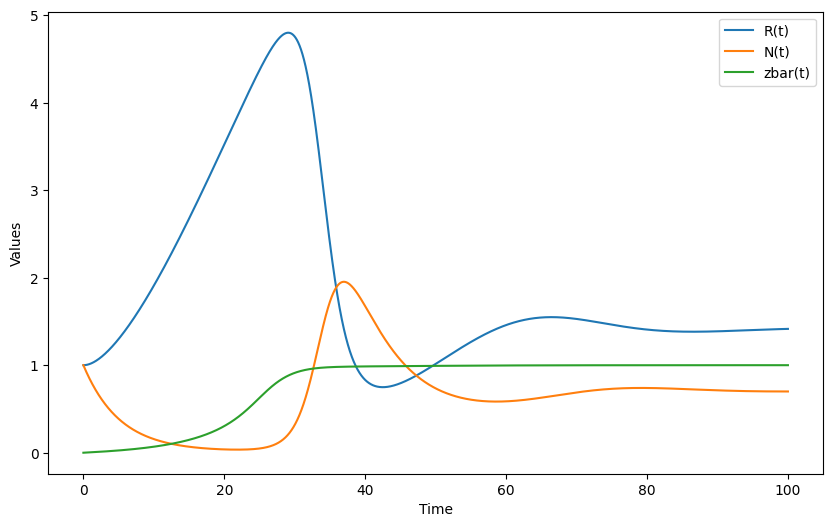

In [5]:
##############
## SIMULATE ##
##############

# Example parameters and initial conditions
R0 = torch.tensor(1.0)
N0 = torch.tensor(1.0)
zbar0 = torch.tensor(0.0)
t0 = 0.0
tf = 100.0
dt = 0.01
iota = torch.tensor(.2)
alpha = torch.tensor(.2)
beta = torch.tensor(.2)
zopt = torch.tensor(1.0)
sigma_z = torch.tensor(.3)
sigma_opt = torch.tensor(.3)

# Run the simulation
t, R_values, N_values, zbar_values = euler_forward(R0, N0, zbar0, t0, tf, dt, iota, alpha, beta, zopt, sigma_z, sigma_opt)

# Plotting results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, R_values, label='R(t)')
plt.plot(t, N_values, label='N(t)')
plt.plot(t, zbar_values, label='zbar(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

#
###

In [6]:
######################################
## COMPUTE PHENOTYPIC DISTRIBUTIONS ##
######################################

# Parameters for the phenotype range and resolution
phenotype_range = [-1.0, 2.0]
num_points = 100

# Compute the normalized distribution
phenotype_values, normalized_distribution = compute_normalized_distribution(zbar_values, sigma_z, phenotype_range, num_points)

# Compute the non-normalized distribution
non_normalized_distribution = normalized_distribution * N_values[:, None]

# Convert the tensors to numpy arrays for plotting
phenotype_values_np = phenotype_values.numpy()
normalized_distribution_np = normalized_distribution.numpy()
non_normalized_distribution_np = non_normalized_distribution.numpy()
t_np = t.numpy()

#
###

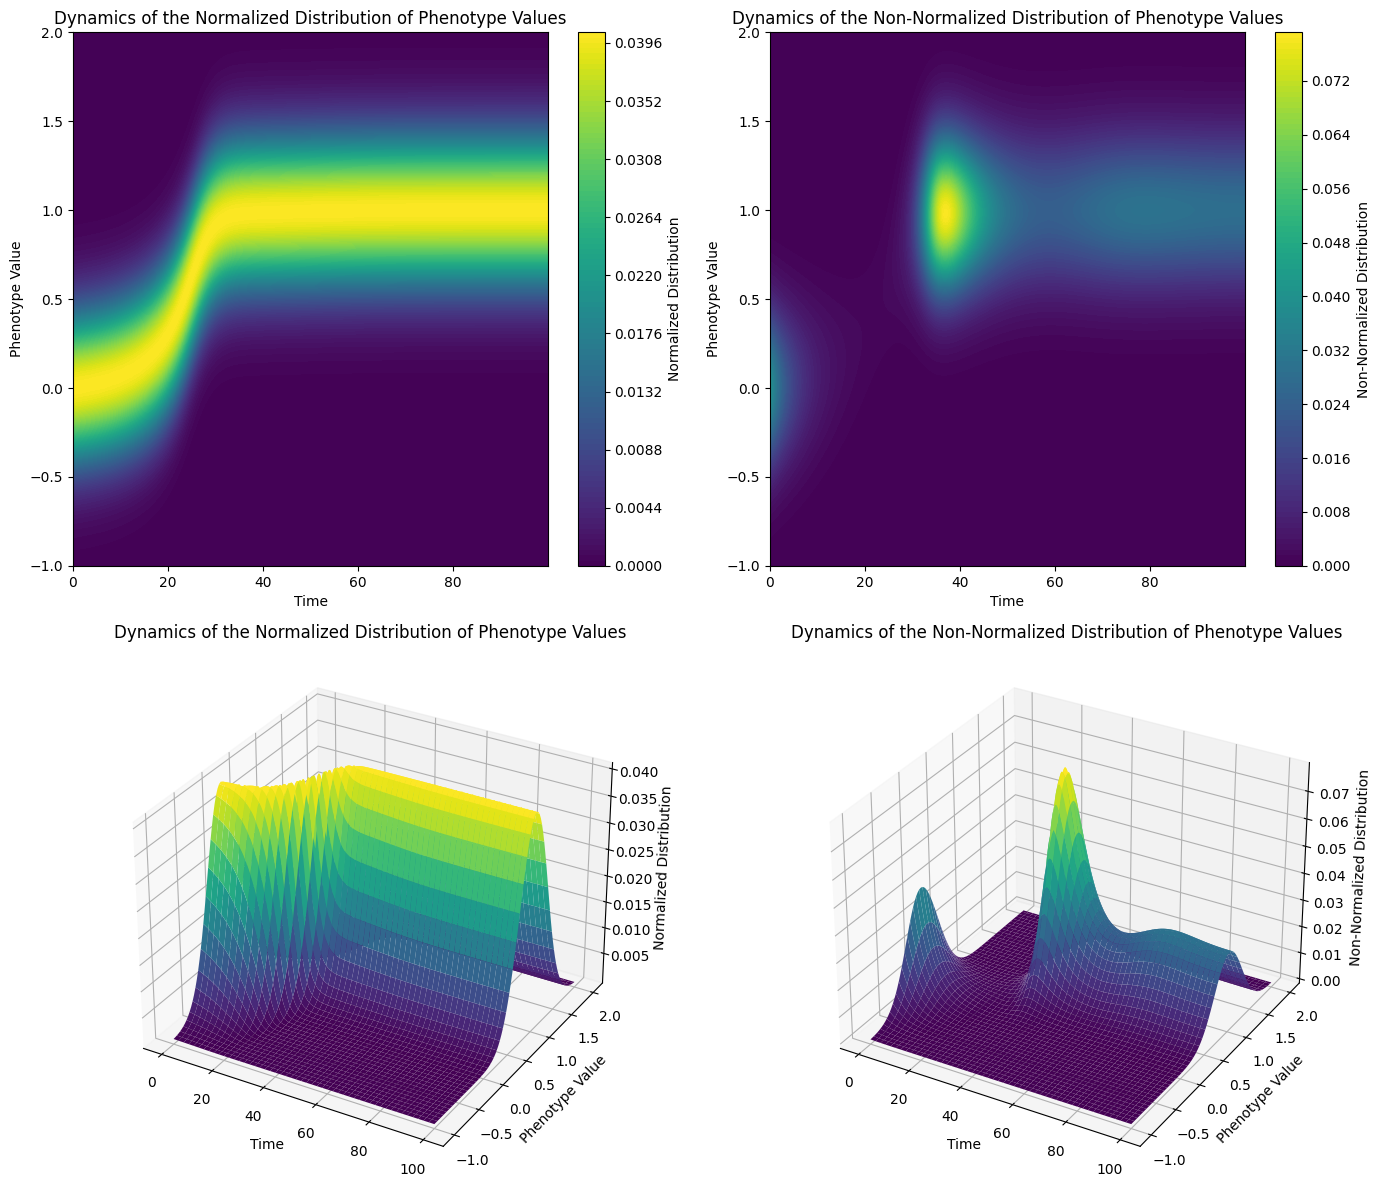

In [7]:
###############################################
## VISUALISATIONS OF PHENOTYPE DISTRIBUTIONS ##
###############################################

# Create the figure with 4 subplots
fig = plt.figure(figsize=(14, 12))

# Normalized distribution contour plot
ax1 = fig.add_subplot(221)
X, Y = np.meshgrid(t_np, phenotype_values_np)
contour1 = ax1.contourf(X, Y, normalized_distribution_np.T, levels=100, cmap='viridis')
ax1.set_xlabel('Time')
ax1.set_ylabel('Phenotype Value')
ax1.set_title('Dynamics of the Normalized Distribution of Phenotype Values')
fig.colorbar(contour1, ax=ax1, label='Normalized Distribution')

# Non-normalized distribution contour plot
ax2 = fig.add_subplot(222)
contour2 = ax2.contourf(X, Y, non_normalized_distribution_np.T, levels=100, cmap='viridis')
ax2.set_xlabel('Time')
ax2.set_ylabel('Phenotype Value')
ax2.set_title('Dynamics of the Non-Normalized Distribution of Phenotype Values')
fig.colorbar(contour2, ax=ax2, label='Non-Normalized Distribution')

# Normalized distribution surface plot
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X, Y, normalized_distribution_np.T, cmap='viridis')
ax3.set_xlabel('Time')
ax3.set_ylabel('Phenotype Value')
ax3.set_zlabel('Normalized Distribution')
ax3.set_title('Dynamics of the Normalized Distribution of Phenotype Values')

# Non-normalized distribution surface plot
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X, Y, non_normalized_distribution_np.T, cmap='viridis')
ax4.set_xlabel('Time')
ax4.set_ylabel('Phenotype Value')
ax4.set_zlabel('Non-Normalized Distribution')
ax4.set_title('Dynamics of the Non-Normalized Distribution of Phenotype Values')

plt.tight_layout()
plt.show()

#
###

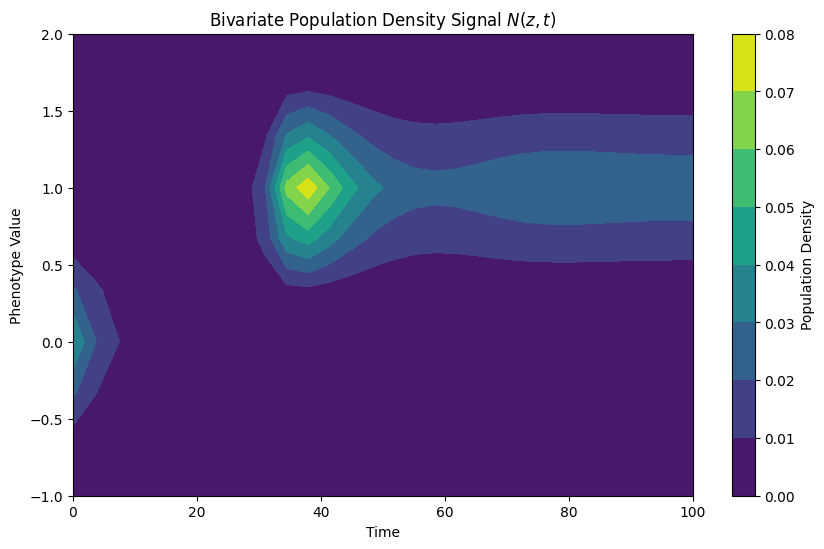

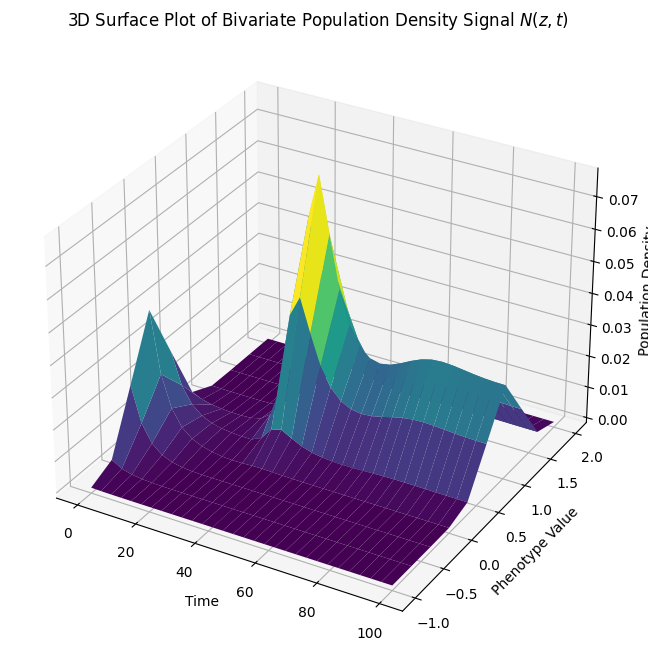

In [8]:
###################################
## CREATE ARTIFICIAL TIME SERIES ##
###################################

# Function to rescale the non-normalized distribution to match the desired dimensions
def rescale_distribution(non_normalized_distribution, num_time_steps, num_phenotype_steps):
    time_indices = np.linspace(0, non_normalized_distribution.shape[0] - 1, num_time_steps).astype(int)
    phenotype_indices = np.linspace(0, non_normalized_distribution.shape[1] - 1, num_phenotype_steps).astype(int)
    rescaled_distribution = non_normalized_distribution[np.ix_(time_indices, phenotype_indices)]
    return rescaled_distribution

# Define the desired dimensions
num_time_steps = 30
num_phenotype_steps = 10

# Rescale the non-normalized distribution
rescaled_distribution = rescale_distribution(non_normalized_distribution_np, num_time_steps, num_phenotype_steps)

# Generate time and phenotype steps
time = np.linspace(0, tf, num_time_steps)
phenotype = np.linspace(phenotype_range[0], phenotype_range[1], num_phenotype_steps)

# Create meshgrid for phenotype and time
Z, T = np.meshgrid(phenotype, time)

# Visualize the rescaled non-normalized distribution (2D contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, rescaled_distribution, cmap='viridis')
plt.colorbar(label='Population Density')
plt.xlabel('Time')
plt.ylabel('Phenotype Value')
plt.title('Bivariate Population Density Signal $N(z, t)$')
plt.show()

# Visualize the rescaled non-normalized distribution (3D surface plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, Z, rescaled_distribution, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Phenotype Value')
ax.set_zlabel('Population Density')
ax.set_title('3D Surface Plot of Bivariate Population Density Signal $N(z, t)$')
plt.show()

#
###

### Bivariate SinExp Model

The `BivariateSinExpModel` is designed to model the relationship between phenotype values \(z\) and time \(t\) using a combination of Gaussian Radial Basis Functions (RBFs) and sinusoidal functions. The model captures complex interactions between these variables, which are useful for interpolating the dynamics of the population phenotype distribution.

#### Model Structure

The model computes three sets of basis functions $ \Psi_1(z) $, $ \Psi_2(z) $, and $ \Psi_3(z) $ as follows:

\begin{equation}
\Psi_1(z) = \sum_{j=1}^{n_1} \Phi_{1,1}^{(j)} \cdot \exp\left(-\left(\Phi_{1,2}^{(j)} \cdot z + \Phi_{1,3}^{(j)}\right)^2\right)
\end{equation}

\begin{equation}
\Psi_2(z) = \sum_{j=1}^{n_2} \Phi_{2,1}^{(j)} \cdot \exp\left(-\left(\Phi_{2,2}^{(j)} \cdot z + \Phi_{2,3}^{(j)}\right)^2\right)
\end{equation}

\begin{equation}
\Psi_3(z) = \sum_{j=1}^{n_3} \Phi_{3,1}^{(j)} \cdot \exp\left(-\left(\Phi_{3,2}^{(j)} \cdot z + \Phi_{3,3}^{(j)}\right)^2\right)
\end{equation}

These basis functions are then used to generate a bivariate signal \(N(t, z)\):

\begin{equation}
N(t, z) = \sum_{i=1}^{m} \Psi_1(z) \cdot \sin\left(\Psi_2(z) \cdot t + \Psi_3(z)\right)
\end{equation}

#### Temporal Derivative

The temporal derivative of the bivariate signal with respect to time \(t\) is computed as follows:

\begin{equation}
\frac{\partial N(t, z)}{\partial t} = \sum_{i=1}^{m} \Psi_1(z) \cdot \Psi_2(z) \cdot \cos\left(\Psi_2(z) \cdot t + \Psi_3(z)\right)
\end{equation}

### Summary

The `BivariateSinExpModel` effectively combines Gaussian RBFs to model the spatial (phenotype) variations and sinusoidal functions to capture the temporal dynamics. This model is particularly useful for capturing complex, nonlinear interactions between phenotype and time in population dynamics data.


In [9]:
###################################
## BIVARIATE INTERPOLATION MODEL ##
###################################

# Model Definition
class BivariateSinusoidalModel(torch.nn.Module):
    def __init__(self, num_functions_L1, num_functions_L2):
        super(BivariateSinusoidalModel, self).__init__()
        self.num_functions_L1 = num_functions_L1
        self.num_functions_L2 = num_functions_L2

        # Parameters for RBF weights
        self.Phi_1_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_1_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_1_3 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_2_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_2_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_2_3 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_3_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_3_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_3_3 = torch.nn.Parameter(torch.randn(num_functions_L1))

    def forward(self, z, t):
        Psi_1 = torch.sum(self.Phi_1_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_1_2[None, :, None] * z[:, None, None] + self.Phi_1_3[None, :, None]), dim=1)
        Psi_2 = torch.sum(self.Phi_2_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_2_2[None, :, None] * z[:, None, None] + self.Phi_2_3[None, :, None]), dim=1)
        Psi_3 = torch.sum(self.Phi_3_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_3_2[None, :, None] * z[:, None, None] + self.Phi_3_3[None, :, None]), dim=1)

        # Bivariate signal
        N = torch.sum(Psi_1[None, :] * torch.sin(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2)
        return N

    def temporal_derivative(self, z, t):
        Psi_1 = torch.sum(self.Phi_1_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_1_2[None, :, None] * z[:, None, None] + self.Phi_1_3[None, :, None]), dim=1)
        Psi_2 = torch.sum(self.Phi_2_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_2_2[None, :, None] * z[:, None, None] + self.Phi_2_3[None, :, None]), dim=1)
        Psi_3 = torch.sum(self.Phi_3_1[None, :, :].transpose(1,2) * torch.sin(self.Phi_3_2[None, :, None] * z[:, None, None] + self.Phi_3_3[None, :, None]), dim=1)

        # Temporal derivative of the bivariate signal
        # dNdt  = torch.sum(Psi_1[None, :] * Psi_2[None, :] * torch.cos(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2) # Solution written before prompting ChatGPT4o
        dN_dt = torch.sum(Psi_1[None, :] * Psi_2[None, :] * torch.cos(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2) # Solution provided by ChatGPT4o
        return dN_dt

# Model Definition
class BivariateSinExpModel(torch.nn.Module):
    def __init__(self, num_functions_L1, num_functions_L2):
        super(BivariateSinExpModel, self).__init__()
        self.num_functions_L1 = num_functions_L1
        self.num_functions_L2 = num_functions_L2

        # Parameters for RBF weights
        self.Phi_1_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_1_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_1_3 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_2_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_2_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_2_3 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_3_1 = torch.nn.Parameter(torch.randn(num_functions_L2, num_functions_L1))
        self.Phi_3_2 = torch.nn.Parameter(torch.randn(num_functions_L1))
        self.Phi_3_3 = torch.nn.Parameter(torch.randn(num_functions_L1))

    def forward(self, z, t):
        Psi_1 = torch.sum(self.Phi_1_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_1_2[None, :, None] * z[:, None, None] + self.Phi_1_3[None, :, None])**2), dim=1)
        Psi_2 = torch.sum(self.Phi_2_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_2_2[None, :, None] * z[:, None, None] + self.Phi_2_3[None, :, None])**2), dim=1)
        Psi_3 = torch.sum(self.Phi_3_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_3_2[None, :, None] * z[:, None, None] + self.Phi_3_3[None, :, None])**2), dim=1)

        # Bivariate signal
        N = torch.sum(Psi_1[None, :] * torch.sin(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2)
        return N

    def temporal_derivative(self, z, t):
        Psi_1 = torch.sum(self.Phi_1_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_1_2[None, :, None] * z[:, None, None] + self.Phi_1_3[None, :, None])**2), dim=1)
        Psi_2 = torch.sum(self.Phi_2_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_2_2[None, :, None] * z[:, None, None] + self.Phi_2_3[None, :, None])**2), dim=1)
        Psi_3 = torch.sum(self.Phi_3_1[None, :, :].transpose(1,2) * torch.exp(-(self.Phi_3_2[None, :, None] * z[:, None, None] + self.Phi_3_3[None, :, None])**2), dim=1)

        # Temporal derivative of the bivariate signal
        # dNdt  = torch.sum(Psi_1[None, :] * Psi_2[None, :] * torch.cos(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2) # Solution written before prompting ChatGPT4o
        dN_dt = torch.sum(Psi_1[None, :] * Psi_2[None, :] * torch.cos(Psi_2[None, :] * t[:, None, None] + Psi_3[None, :]), dim=2) # Solution provided by ChatGPT4o
        return dN_dt

#
###

In [10]:
#######################################################
## BIVARIATE INTERPOLATION OF ARTIFICIAL TIME SERIES ##
#######################################################

# Convert to tensors
z_tensor = torch.tensor(phenotype, dtype=torch.float32)
t_tensor = torch.tensor(time, dtype=torch.float32)

# Generate ground truth data
population_density_bivariate = rescaled_distribution
log_population_density_bivariate = np.log(rescaled_distribution)
log_N_mean = np.mean(log_population_density_bivariate)
log_N_std = np.std(log_population_density_bivariate)
std_log_population_density_bivariate = (log_population_density_bivariate - log_N_mean)/log_N_std
population_density_bivariate_tensor = torch.tensor(population_density_bivariate, dtype=torch.float32)
log_population_density_bivariate_tensor = torch.tensor(log_population_density_bivariate, dtype=torch.float32)
std_log_population_density_bivariate_tensor = torch.tensor(std_log_population_density_bivariate, dtype=torch.float32)

# Initialize the model
M = 100 # Number of RBFs
K = 100 # Number of sinusoids
model = BivariateSinExpModel(num_functions_L1=M, num_functions_L2=K)
# model = BivariateSinusoidalModel(num_functions_L1=M, num_functions_L2=K)

# Loss Function
loss_fn = torch.nn.MSELoss()

# Define L2 regularization parameter
l2_lambda = 0.0 # Adjust this value as needed

# Training Loop
def closure():
    optimizer.zero_grad()
    prediction = model(z_tensor, t_tensor)
    loss = loss_fn(prediction, std_log_population_density_bivariate_tensor)

    # L2 regularization
    l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
    loss += l2_lambda * l2_norm

    loss.backward()
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 1000 * 2
for epoch in range(num_epochs):
    optimizer.step(closure)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 2000 * 2
for epoch in range(num_epochs):
    optimizer.step(closure)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3000 * 2
for epoch in range(num_epochs):
    optimizer.step(closure)


# Evaluate the model
model.eval()
with torch.no_grad():
    predicted_density = model(z_tensor, t_tensor).numpy()

#
###

Epoch [1000/2000], Loss: 0.2016
Epoch [2000/2000], Loss: 0.2005
Epoch [1000/4000], Loss: 0.1231
Epoch [2000/4000], Loss: 0.0852
Epoch [3000/4000], Loss: 0.0880
Epoch [4000/4000], Loss: 0.0795
Epoch [1000/6000], Loss: 0.0786
Epoch [2000/6000], Loss: 0.0750
Epoch [3000/6000], Loss: 0.0733
Epoch [4000/6000], Loss: 0.0732
Epoch [5000/6000], Loss: 0.0727
Epoch [6000/6000], Loss: 0.0726


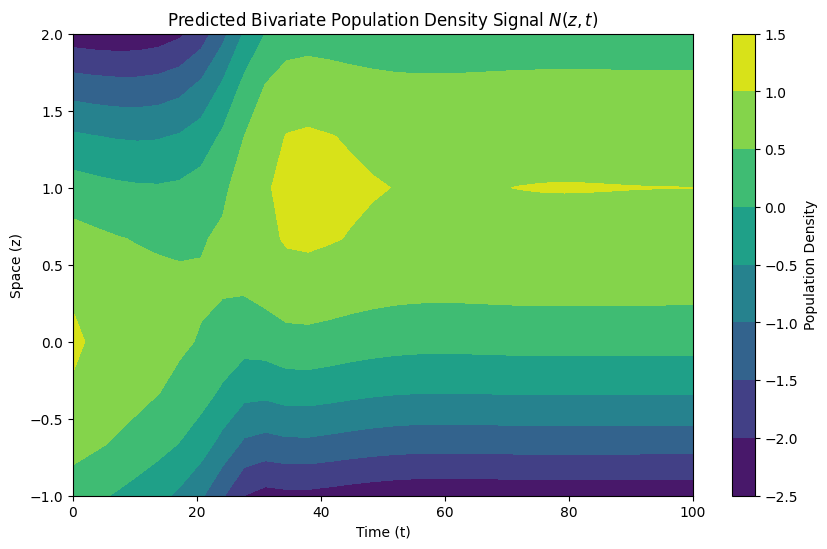

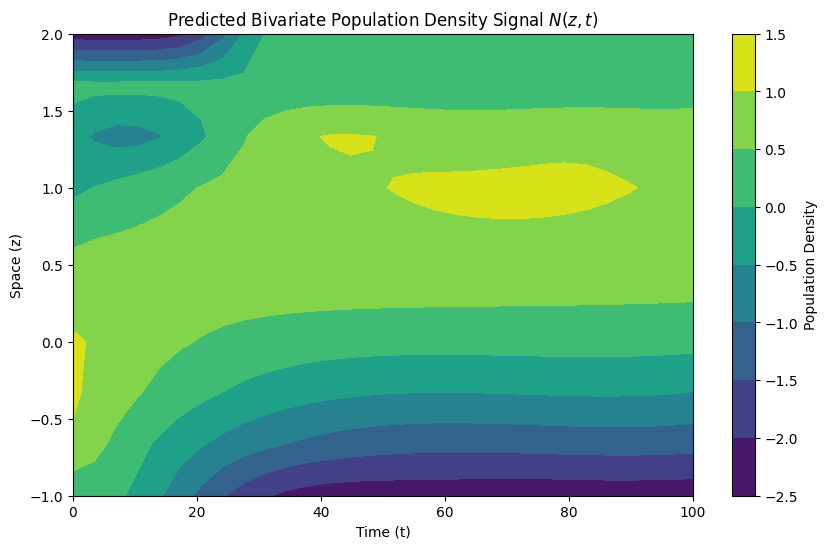

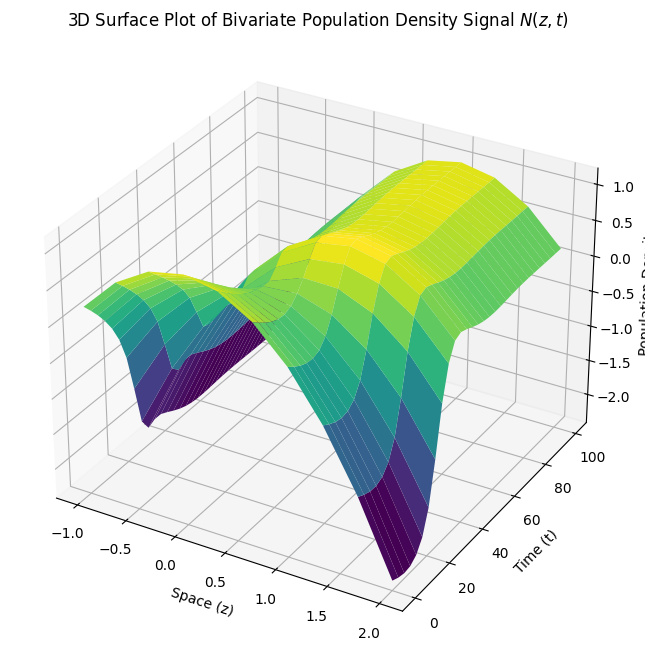

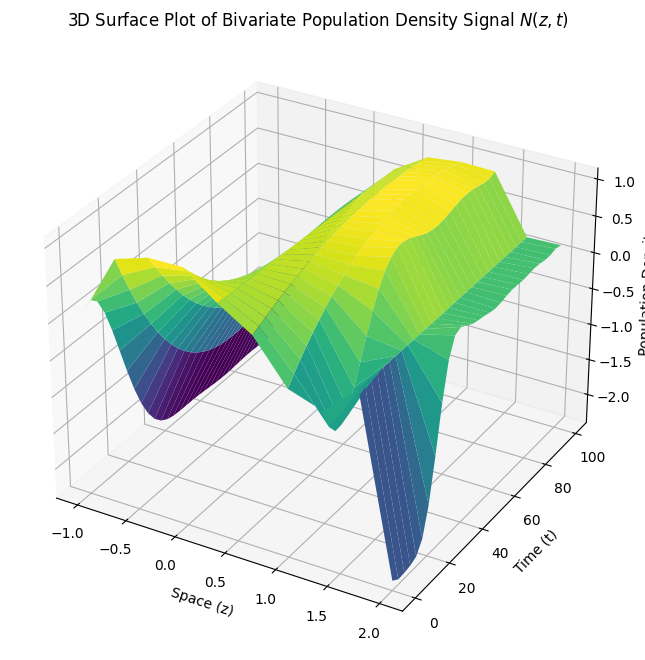

In [11]:
####################
## VISUALISATIONS ##
####################

# Plot the results
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, std_log_population_density_bivariate, cmap='viridis')
plt.colorbar(label='Population Density')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('Predicted Bivariate Population Density Signal $N(z, t)$')
plt.show()

# Plot the results
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, predicted_density, cmap='viridis')
plt.colorbar(label='Population Density')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('Predicted Bivariate Population Density Signal $N(z, t)$')
plt.show()

# Visualize the bivariate ground truth (3D surface plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, T, std_log_population_density_bivariate, cmap='viridis')
ax.set_xlabel('Space (z)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Population Density')
ax.set_title('3D Surface Plot of Bivariate Population Density Signal $N(z, t)$')
plt.show()

# Visualize the bivariate prediction (3D surface plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, T, predicted_density, cmap='viridis')
ax.set_xlabel('Space (z)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Population Density')
ax.set_title('3D Surface Plot of Bivariate Population Density Signal $N(z, t)$')
plt.show()

#
###

In [12]:
####################################
## COMPUTING TEMPORAL DERIVATIVES ##
####################################

# Compute model temporal derivative
model.eval()
with torch.no_grad():
    predicted_t_derivative = model.temporal_derivative(z_tensor, t_tensor).detach().numpy()

#
###

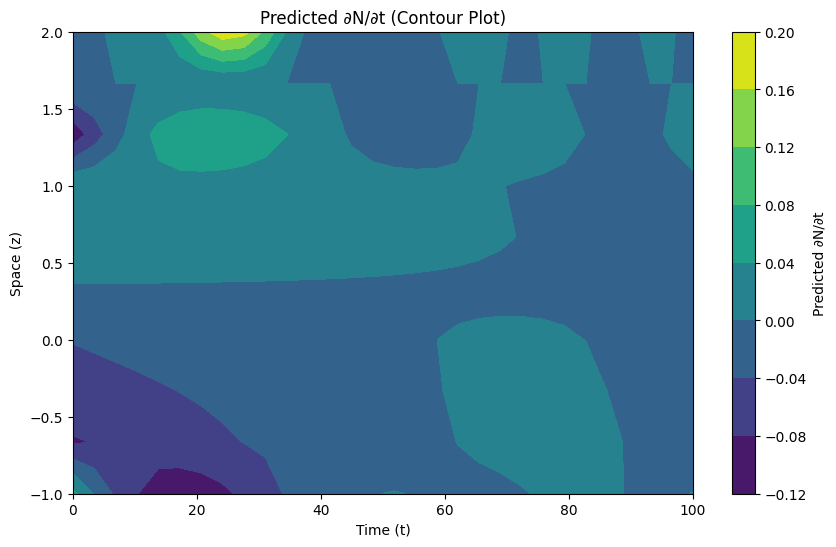

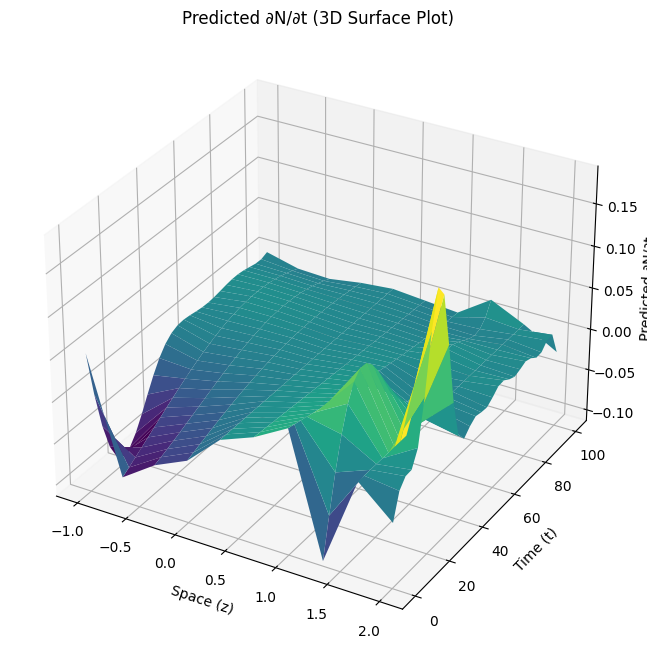

In [13]:
####################
## VISUALISATIONS ##
####################

# Visualize the predicted t-derivative (contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, predicted_t_derivative, cmap='viridis')
plt.colorbar(label='Predicted ∂N/∂t')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('Predicted ∂N/∂t (Contour Plot)')
plt.show()

# Visualize the predicted t-derivative (3D surface plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, T, predicted_t_derivative, cmap='viridis')
ax.set_xlabel('Space (z)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Predicted ∂N/∂t')
ax.set_title('Predicted ∂N/∂t (3D Surface Plot)')
plt.show()

#
###

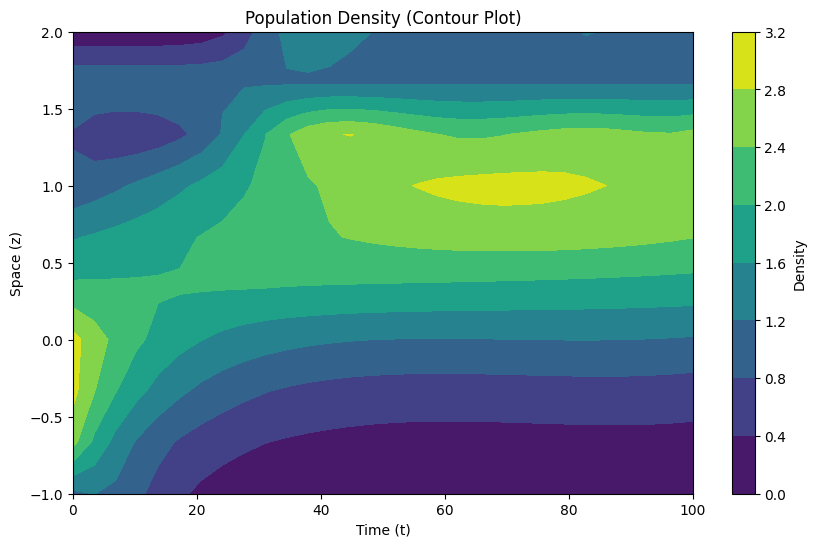

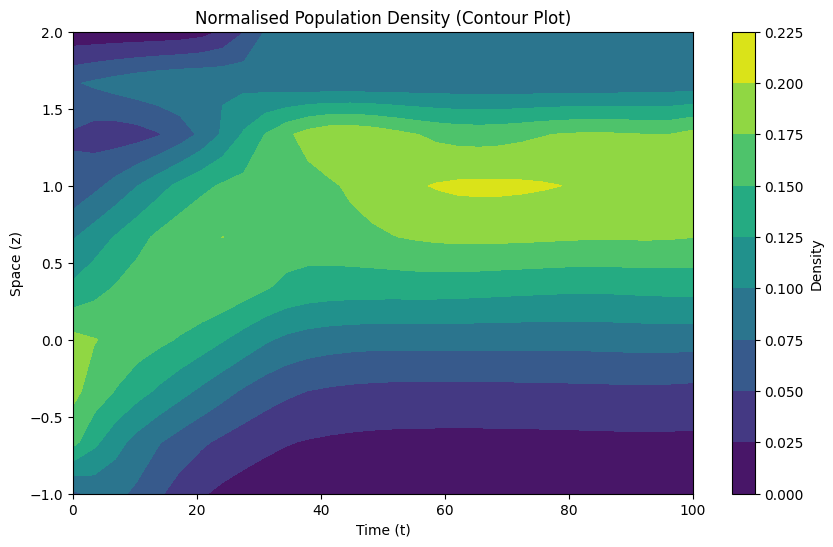

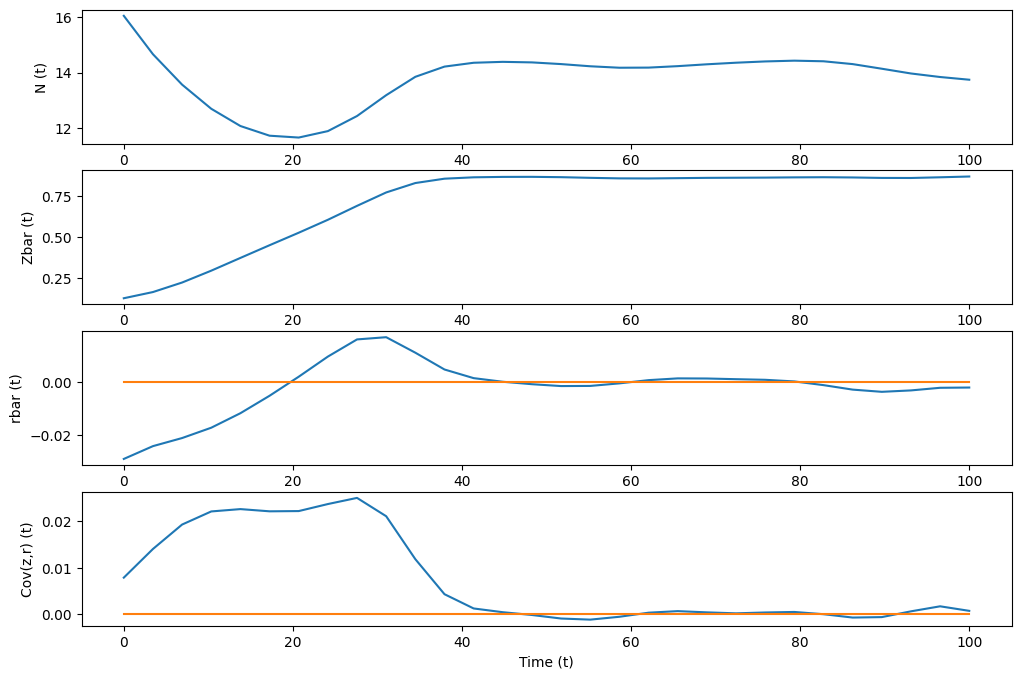

In [14]:
##########################
## EVALUATE PRICE MODEL ##
##########################

# Compute model temporal derivative
model.eval()
with torch.no_grad():
    log_density = model(z_tensor, t_tensor).numpy()
    ddt_log_density = model.temporal_derivative(z_tensor, t_tensor).detach().numpy()

## Quantities
density = np.exp(log_density)
ndensity = density/density.sum(1).reshape(-1,1)
Ntot = density.sum(1)
zbar = (Z * ndensity).sum(1)
rbar = (ddt_log_density * ndensity).sum(1)
zrbar = (Z * ddt_log_density * ndensity).sum(1)
cov_zr = zrbar - zbar*rbar
# print(log_density.shape)

# Visualize the ground truth t-derivative (contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T.T, Z.T, density.T, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('Population Density (Contour Plot)')
plt.show()

# Visualize the ground truth t-derivative (contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T.T, Z.T, ndensity.T, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Time (t)')
plt.ylabel('Space (z)')
plt.title('Normalised Population Density (Contour Plot)')
plt.show()

## Visualise Derived Quantitites
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

# Visualize the ground truth t-derivative (contour plot)
ax = axes[0]
ax.plot(T[:,0], Ntot)
ax.set_xlabel('Time (t)')
ax.set_ylabel('N (t)')

# Visualize the ground truth t-derivative (contour plot)
ax = axes[1]
ax.plot(T[:,0], zbar)
ax.set_xlabel('Time (t)')
ax.set_ylabel('Zbar (t)')

# Visualize the ground truth t-derivative (contour plot)
ax = axes[2]
ax.plot(T[:,0], rbar)
ax.plot(T[:,0], np.repeat(0,len(T[:,0])))
ax.set_xlabel('Time (t)')
ax.set_ylabel('rbar (t)')

# Visualize the ground truth t-derivative (contour plot)
ax = axes[3]
ax.plot(T[:,0], cov_zr)
ax.plot(T[:,0], np.repeat(0,len(T[:,0])))
ax.set_xlabel('Time (t)')
ax.set_ylabel('Cov(z,r) (t)')

## End
plt.show()
plt.close()

#
###

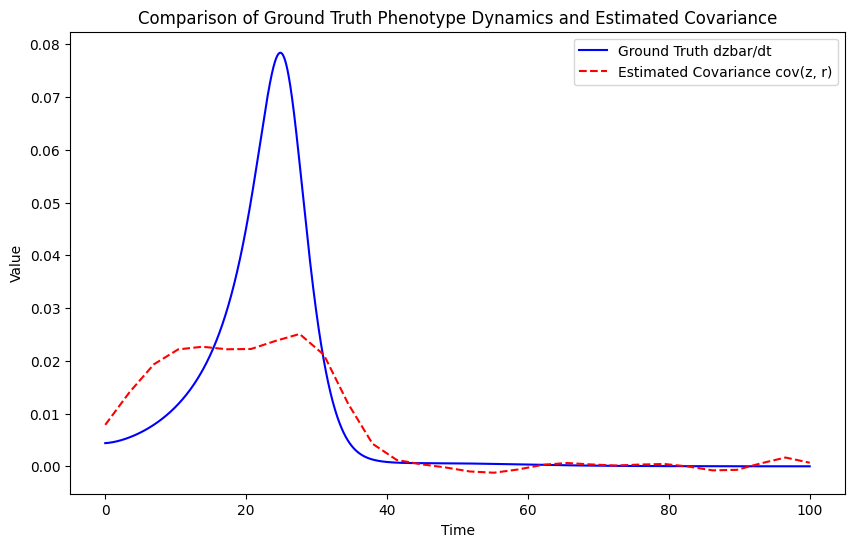

In [15]:
##################################
## COMPARISON WITH GROUND TRUTH ##
##################################

# Calculate ground truth dynamics using the dzbar_dt function
# Assuming you have the necessary inputs (R, alpha, zbar_values, zopt, sigma_z, sigma_opt)
ground_truth_dzbar_dt = dzbar_dt(R_values, alpha, zbar_values, zopt, sigma_z, sigma_opt)

# Plot ground truth dynamics and estimated covariance
plt.figure(figsize=(10, 6))

plt.plot(t, ground_truth_dzbar_dt, label='Ground Truth dzbar/dt', color='blue')
plt.plot(T[:,0], cov_zr, label='Estimated Covariance cov(z, r)', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Ground Truth Phenotype Dynamics and Estimated Covariance')
plt.legend()
plt.show()

#
###

## Supplementary

In [16]:
##############################
## UNIVARIATE INTERPOLATION ##
##############################

# Step 1: Generate Artificial Time Series Data
num_time_steps = 100  # Number of time steps

# Generate time steps
time = np.linspace(0, 2 * np.pi, num_time_steps)

zbar_mean = np.mean(zbar)
zbar_std = np.std(zbar)
target = (zbar - zbar_mean)/zbar_std

# Convert data to PyTorch tensors
time_tensor = torch.tensor(time, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(target, dtype=torch.float32)

# Number of sinusoids
N = 10

# Step 2: Define the Model
class SinusoidalModel(torch.nn.Module):
    def __init__(self, num_sinusoids, num_time_steps):
        super(SinusoidalModel, self).__init__()
        self.num_sinusoids = num_sinusoids
        self.amplitudes = torch.nn.Parameter(torch.randn(num_sinusoids))
        self.phases = torch.nn.Parameter(torch.randn(num_sinusoids))
        self.frequencies = torch.nn.Parameter(torch.randn(num_sinusoids))
        self.time = torch.arange(num_time_steps).float()

    def forward(self, t):
        sinusoidal_sum = torch.zeros_like(t)
        for i in range(self.num_sinusoids):
            sinusoidal_sum += self.amplitudes[i] * torch.sin(self.frequencies[i] * t + self.phases[i])
        return sinusoidal_sum

# Step 3: Define the Loss Function with L2 Regularization
def loss_fn(prediction, target, model, lambda_reg):
    mse_loss = torch.nn.functional.mse_loss(prediction, target)
    l2_reg = lambda_reg * (torch.sum(model.amplitudes ** 2) + torch.sum(model.phases ** 2) + torch.sum(model.frequencies ** 2))
    return mse_loss + l2_reg

# Regularization parameter
lambda_reg = 0.0

# Step 4: Set Up the Optimizer
model = SinusoidalModel(N, num_time_steps)
optimizer = optim.LBFGS(model.parameters(), history_size=10, max_iter=20)

# Step 5: Train the Model
def closure():
    optimizer.zero_grad()
    prediction = model(time_tensor)
    loss = loss_fn(prediction, target_tensor, model, lambda_reg)
    loss.backward()
    return loss

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.step(closure)

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(time_tensor).numpy()

# Step 6: Compute Derivatives
# Compute the derivative of the predicted population density with respect to time
predicted_tensor = model(time_tensor)
predicted_tensor.backward(torch.ones_like(time_tensor))
predicted_derivative = time_tensor.grad.numpy()

## Store variable
zbar_int = predicted * zbar_std + zbar_mean
ddt_zbar_int = predicted_derivative * zbar_std

#
###

<ipython-input-16-ab4f9c2eafe4>:40: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = torch.nn.functional.mse_loss(prediction, target)


RuntimeError: The size of tensor a (100) must match the size of tensor b (30) at non-singleton dimension 0

In [ ]:
###################
## VISUALISATION ##
###################

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, zbar, label='Target')
plt.plot(time, zbar_int, label='Predicted', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('zbar (t)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, ddt_zbar_int, label='Predicted Derivative', linestyle='dashed')
plt.plot(time, np.repeat(0, len(time)), linestyle='dashed', color='black', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('dzbar/dt (t)')
plt.legend()

plt.tight_layout()
plt.show()

#
###

In [ ]:
####################################
## ANALYSIS OF PHENOTYPE DYNAMICS ##
####################################

## Dynamics of mean phenotype
E_dzdt = ddt_zbar_int - cov_zr

## Comparison with covariance
plt.figure(figsize=(12,8))
plt.plot(time, np.repeat(0, len(time)), linestyle='dashed', color='black', alpha=0.5)
plt.plot(time, ddt_zbar_int, label='dzbar/dt')
plt.plot(time, cov_zr, label='Cov(z,r)')
plt.plot(time, E_dzdt, label='E[dz/dt]')
plt.xlabel('Time (t)')
plt.ylabel('Value')
plt.legend()
plt.show()
plt.close()

#
###

In [ ]:
########################################
## BASIC NEURAL NETWORK INTERPOLATION ##
########################################

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'rescaled_distribution' is your data and 'time' and 'phenotype' are your axes.
population_density_bivariate = rescaled_distribution
log_population_density_bivariate = np.log(rescaled_distribution)
log_N_mean = np.mean(log_population_density_bivariate)
log_N_std = np.std(log_population_density_bivariate)
std_log_population_density_bivariate = (log_population_density_bivariate - log_N_mean) / log_N_std
std_log_population_density_bivariate_tensor = torch.tensor(std_log_population_density_bivariate, dtype=torch.float32)

# Flatten the data to fit a model
X = np.array([[t, z] for t in time for z in phenotype])
y = std_log_population_density_bivariate.flatten()

# Convert to PyTorch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

# Define a simple neural network model for interpolation
class InterpolationModel(torch.nn.Module):
    def __init__(self):
        super(InterpolationModel, self).__init__()
        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def temporal_derivative(self, X):
        X.requires_grad_(True)
        y = self.forward(X)
        dy_dt = torch.autograd.grad(outputs=y, inputs=X, grad_outputs=torch.ones_like(y), create_graph=True)[0][:, 0]
        return dy_dt

# Initialize the model
model = InterpolationModel()

# Define the loss function
criterion = torch.nn.MSELoss()

# Use the Adam optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_torch).squeeze()
    loss = criterion(outputs, y_torch)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Model evaluation
model.eval()
with torch.no_grad():
    standardized_predictions = model(X_torch).numpy().reshape(rescaled_distribution.shape)
standardized_temporal_derivatives = model.temporal_derivative(X_torch).detach().numpy().reshape(rescaled_distribution.shape)

# De-standardize and de-transform predictions
log_density = standardized_predictions * log_N_std + log_N_mean
density = np.exp(log_density)

# Compute the temporal derivative
log_temporal_derivatives = standardized_temporal_derivatives * log_N_std
temporal_derivatives = np.exp(log_predictions) * log_temporal_derivatives

# Quantities
ndensity = density / density.sum(axis=1).reshape(-1, 1)
Ntot = density.sum(axis=1)
zbar = (Z * ndensity).sum(axis=1)
rbar = (temporal_derivatives * ndensity).sum(axis=1)
zrbar = (Z * temporal_derivatives * ndensity).sum(axis=1)
cov_zr = zrbar - zbar * rbar

# Visualize the ground truth t-derivative (contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, density, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Time (t)')
plt.ylabel('Phenotype (z)')
plt.title('Population Density (Contour Plot)')
plt.show()

# Visualize the normalized population density (contour plot)
plt.figure(figsize=(10, 6))
plt.contourf(T, Z, ndensity, cmap='viridis')
plt.colorbar(label='Normalized Density')
plt.xlabel('Time (t)')
plt.ylabel('Phenotype (z)')
plt.title('Normalized Population Density (Contour Plot)')
plt.show()

# Visualize Derived Quantities
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Total Population Density
ax = axes[0]
ax.plot(time, Ntot)
ax.set_xlabel('Time (t)')
ax.set_ylabel('N(t)')
ax.set_title('Total Population Density')

# Mean Phenotype
ax = axes[1]
ax.plot(time, zbar)
ax.set_xlabel('Time (t)')
ax.set_ylabel('zbar(t)')
ax.set_title('Mean Phenotype')

# Mean Temporal Derivative of Log Density
ax = axes[2]
ax.plot(time, rbar)
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Time (t)')
ax.set_ylabel('rbar(t)')
ax.set_title('Mean Temporal Derivative of Log Density')

# Covariance between Phenotype and Temporal Derivative
ax = axes[3]
ax.plot(time, cov_zr)
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Cov(z,r)(t)')
ax.set_title('Covariance between Phenotype and Temporal Derivative')

plt.tight_layout()
plt.show()
plt.close()

#
###